<a href="https://colab.research.google.com/github/RogerRatnam/TinoClubs/blob/master/Copy_of_Lab17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <a href="https://colab.research.google.com/github/LMU-CMSI-1010/lab-notebooks-original/blob/main/Lab17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 17 Building a Skateboard Ramp
You’ve been doing a lot of skateboarding recently, and now you’re thinking about building your own ramp! But first you need to know how much plywood to buy. If only there was a way to estimate the area under the curve of the skateboard ramp you designed…but wait, there is! Using a technique called [Riemann integration](https://www.khanacademy.org/math/ap-calculus-ab/ab-integration-new/ab-6-2/v/simple-riemann-approximation-using-rectangles), you can break up the polynomial curve that makes up the shape of the ramp into little rectangles, and sum up the area of all those rectangles to estimate the area under the ramp!

(if you have never heard of this before, watch the video—it helps!)

Let’s start with some imports that we’ll be using throughout this notebook…

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Function Classes
For our program design, we have decided to represent our skate ramp curves as `Function` objects. All `Function` objects have a `get_y` method which will return the $y$-coordinate of that curve at the given $x$ coordinate.

To get things started, we’ve defined the base `Function` class and have two subclasses: a `Polynomial` which can represent any polynomial function (observe how a polynomial can be defined solely by its coefficients), and a `Sine`(-ish) function that computes $a\sin x + b$ with an optional coefficient $a$ and offset $b$ (which default to $1$ and $0$ respectively, thus resulting in “plain” $\sin x$).

In [2]:
from math import sin

class Function(object):
    def get_y(self, x):
        # Subclasses must override this.
        return None

class Polynomial(Function):
    def __init__(self, coefficients):
        # coefficients must be a list or tuple of numbers.
        # coefficients[0] is the coefficient for x^0,
        # coefficients[1] is the coefficient for x^1,
        # coefficients[n] is the coefficient for x^n.
        self.coefficients = coefficients
    
    def get_y(self, x):
        """
        Calculates y, given x, for a polynomial curve.
        """
        y = 0.0
        for power in range(0, len(self.coefficients)):
            y = y + self.coefficients[power] * (x ** power)
        
        return y

class SineIsh(Function):
    def __init__(self, coefficient=1, offset=0):
        # coefficient will be multiplied to the sine
        self.coefficient = coefficient

        # offset will be added to coefficient * sine
        self.offset = offset

    def get_y(self, x):
        """
        Calculates y, given x, for a sine curve.
        """
        return self.coefficient * sin(x) + self.offset

**Optional:** Feel free to make more `Function` subclasses! Do you know any that produce some interesting curves?

In [4]:
# Use this code block to define more interesting Function subclasses.
#
# If you define them correctly, you'll be able to "plug" them right
# into the other code below---that's the power of inheritance!

### Function Visualization

The awesome `matplotlib` library makes it super easy to try out these functions—and even make more! Test these function classes standalone.

You can check your work using [Wolfram Alpha](https://www.wolframalpha.com/examples/mathematics/plotting-and-graphics/) to see if you’re computing the curves correctly!

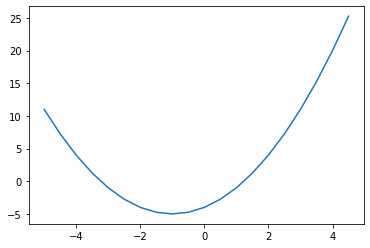

In [3]:
p = Polynomial((-4, 2, 1)) # -4 + 2x + x^2

# The Python below is a touch more advanced than we have seen,
# but it isn't hard to adapt.
domain = np.arange(-5, 5, 0.5) # start, stop, step
plot = plt.plot(list(domain), [p.get_y(x) for x in domain])

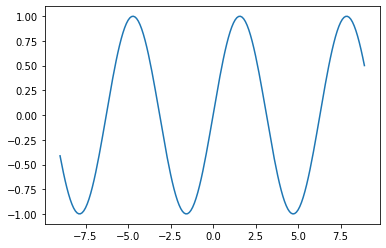

In [4]:
s = SineIsh() # Defaults result in sin(x)

domain = np.arange(-9, 9, 0.1)
plot = plt.plot(list(domain), [s.get_y(x) for x in domain])

## The `SkateRamp` Class Itself
The `SkateRamp` class accepts a `Function` object (actually a `Function` *subclass* object because a plain `Function` doesn’t do anything!) as its `ramp`. It also takes:
* `lower_bound`: the $x$-coordinate where the ramp starts
* `upper_bound`: the $x$-coordinate where the ramp ends
* `percent_diff`: the percentage difference between estimates for which we can say “close enough!” (defaults to 0.01 or 1%—that means if our last estimate was 120 square units and our latest estimate with one more rectangle is 121 square units, then we can stop because the difference between estimates is less than 1%)
The `plot_rects` method has been given to you so that you can visualize the rectangles that have been computed.

The task here is to implement `calculate_area_for_rect` and `estimate_area_under_ramp`—read the docstrings below for more information.

In [23]:
class SkateRamp(object):
    def __init__(self, ramp, lower_bound, upper_bound, percent_diff=0.01):
        # Error-checking.
        if upper_bound < lower_bound:
            raise ValueError('Upper bound must be > lower bound')

        self.ramp = ramp
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.percent_diff = percent_diff

    def plot_rects(self, rects, **kwargs):
        """
        Visualization helper using matplotlib to draw the rectangles
        computed by calculate_area_for_rect_count.
        """
        x = [rect[0] for rect in rects]
        height = [rect[2] for rect in rects]
        width = [rect[1] for rect in rects]
        plt.bar(x, height, width, **kwargs)

    def calculate_area_for_rect_count(self, rect_count):
        """
        Estimates the area under the curve for a specific number of rectangles.
        Returns a tuple consisting of the computed rectangles (midpoint, width,
        height) and their total area.
        """
        total_area = 0.0
        rect_width = (self.upper_bound - self.lower_bound) / rect_count
        rects = []

        # Compute rect_count rectangles.
        for i in range(rect_count):
            # Use the rectangle's midpoint to determine its height.
            midpoint = self.lower_bound + (rect_width/2) + i*rect_width # TODO

            # The height comes from self.ramp.get_y(midpoint)
            # ---that's the value of the function at that
            #    x-coordinate!
            height = self.ramp.get_y(midpoint)

            # The area of the rectangle is its width times its height.
            # Add this to the total area so far.
            total_area += rect_width * height # TODO

            # Each rectangle is its midpoint, width, and height.
            rects.append((midpoint, rect_width, height))

        return rects, total_area

    def estimate_area_under_ramp(self):
        """
        Estimates the area under the curve by calculating the area under an
        increasing number of rectangles, until 2 areas are within
        self.percent_diff of each other.

        Returns a tuple consisting of the number of rectangles required
        and the estimated area.
        """
        previous_area = 0.0 # The area we first calculated.
        new_area = 0.0 # The latest area we have calculated.
        rect_count = 1 # The number of rectangles we're using.

        # Keep going until the new estimate is within self.percent_diff
        # of the previous estimate.
        # TODO
          # Try the current number of rectangles!
        truth = True
        
        rects, new_area = self.calculate_area_for_rect_count(rect_count)
        #print (previous_area,new_area, 'new area', rects, 'rects')
        #print(type(new_area), type(rects))
        #print(type(self.percent_diff), type(abs(new_area)), type(previous_area), type(rect_count))

        while(truth != False):
          # If we are close enough, then we are done!
          if abs(new_area-previous_area) < self.percent_diff and rect_count > 1:  # TODO
              # Visualize the final set of rectangles.
              self.plot_rects(rects, color=(0.5, 0.0, 0.5, 0.25), fill=True)
              break
         #print('hi')
          # We visualize intermediates in a different color, and with
          # decreased opacity.
          self.plot_rects(rects, color=(0.0, 0.5, 0.0, 0.25), fill=True)

          # Get ready for the next estimation---remember the previous area
          # and increase the number of rectangles.
          previous_area = new_area
          rect_count += 1
          rects, new_area = self.calculate_area_for_rect_count(rect_count)

        return rect_count, new_area

### Estimation with a Chosen Number of Rectangles
A good way to pace your work is to implement `calculate_area_for_rect_count` first. That way you can see if a single set of rectangles is being computed correctly.

You can use [this page from Wolfram MathWorld](https://mathworld.wolfram.com/RiemannSum.html) to check your work!

How many rectangles would you like to try? 25
Estimated area using 25 rectangle(s): 585.6000000000003


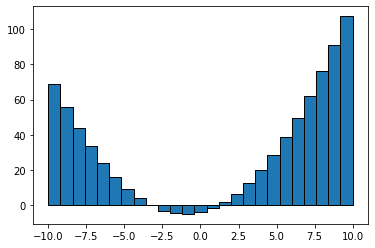

In [6]:
num_rects = int(input('How many rectangles would you like to try? '))
sr = SkateRamp(Polynomial((-4, 2, 1)), -10, 10)
rects, area = sr.calculate_area_for_rect_count(num_rects)
sr.plot_rects(rects, edgecolor=(0, 0, 0))
print(f'Estimated area using {num_rects} rectangle(s):', area)

How many rectangles would you like to try? 12
Estimated area using 12 rectangle(s): 0.2398604827059938


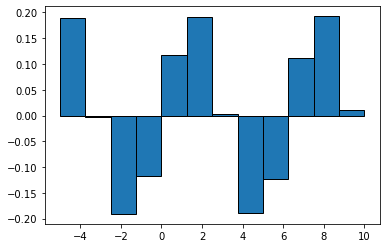

In [11]:
num_rects = int(input('How many rectangles would you like to try? '))
sr = SkateRamp(SineIsh(0.2, 0), -5, 10)
rects, area = sr.calculate_area_for_rect_count(num_rects)
sr.plot_rects(rects, edgecolor=(0, 0, 0))
print(f'Estimated area using {num_rects} rectangle(s):', area)

### Full Estimation
Once you are confident that `calculate_area_for_rect_count` works correctly, you can move on to `estimate_area_under_ramp`.

Don’t hesitate to try out different sets of coefficients or your own `Function` subclasses to see the curve that shows up!

(52, 586.4201183431953)

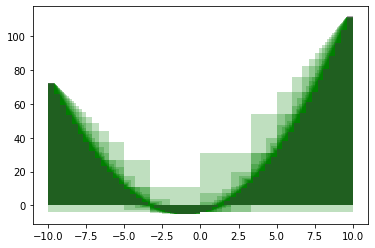

In [24]:
sr = SkateRamp(Polynomial((-4, 2, 1)), -10, 10)
sr.estimate_area_under_ramp()

(9, 0.25280753504872594)

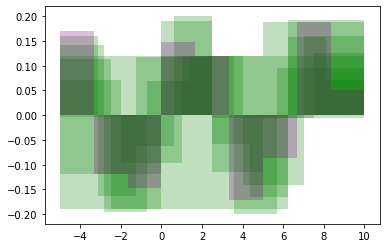

In [25]:
sr = SkateRamp(SineIsh(0.2, 0), -5, 10)
sr.estimate_area_under_ramp()